# Morphological Chan Vese Segmentation

## Parameters Required
1. Algorithm Iterations
2. Contour Area Threshold

In [1]:
import os
os.chdir('..')

In [5]:
from utils.data import get_training_data_for_image_set, extract_contour_bounding_box_masked
from utils.visualize import display_instances_segments
import lung_map_utils
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set,
                                  mark_boundaries
                                 )
%matplotlib inline
a = get_training_data_for_image_set('data/image_set_90')
hsv_img = a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['hsv_img']
sub = extract_contour_bounding_box_masked(
    cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB),
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['regions'][2]['points']
)
sub_hsv = extract_contour_bounding_box_masked(
    hsv_img,
    a['2015-04-029_60X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif']['regions'][2]['points']
)

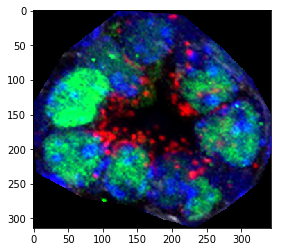

In [3]:
plt.imshow(sub)

### Helper functions

In [7]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

In [20]:
# Morphological ACWE
sub_gray = cv2.cvtColor(sub,cv2.COLOR_RGB2GRAY)
image = img_as_float(sub_gray)

# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 100, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

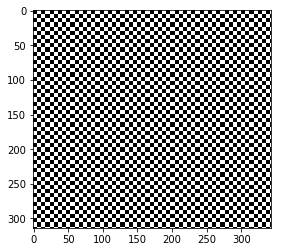

In [21]:
plt.imshow(init_ls*255, cmap='gray')

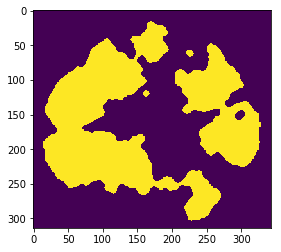

In [22]:
plt.imshow(ls*255)

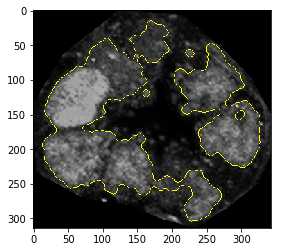

In [23]:
plt.imshow(mark_boundaries(sub_gray, ls))

> Hmm, this does a pretty good job. Let's see if we can't come up with some rules that will "pinch" off some segments. But first, what is the `segments` object?

In [24]:
ls

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [25]:
masked_sub = cv2.bitwise_and(sub, sub, mask=ls)

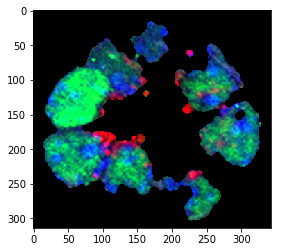

In [26]:
plt.imshow(masked_sub)

In [30]:
_, contours, hierarchy = cv2.findContours(ls.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Found {} contours.".format(str(len(contours))))

Found 5 contours.


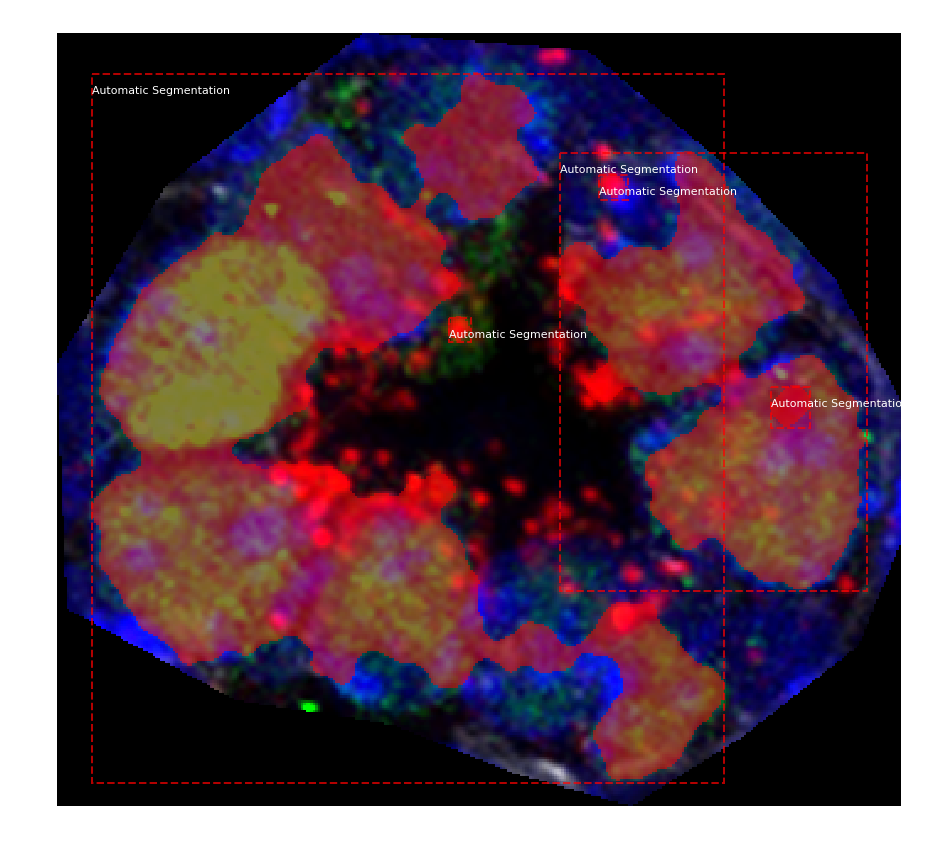

In [31]:
results = []
for contour in contours:
    results.append({'points': contour})

display_instances_segments(
    sub,
    results,
    ['raw']
)

In [32]:
def contour_area_thresholding(list_of_contours, area_thresh=250):
    results_list = []
    results_dict = []
    for contour in list_of_contours:
        area = cv2.contourArea(contour)
        if area>=area_thresh:
            results_dict.append({'points': contour})
            results_list.append(contour)
    return results_list, results_dict

In [33]:
contours_thresh_list, contours_thresh_dict = contour_area_thresholding(contours)
print("{} contours left after thresholding".format(str(len(contours_thresh_list))))

2 contours left after thresholding


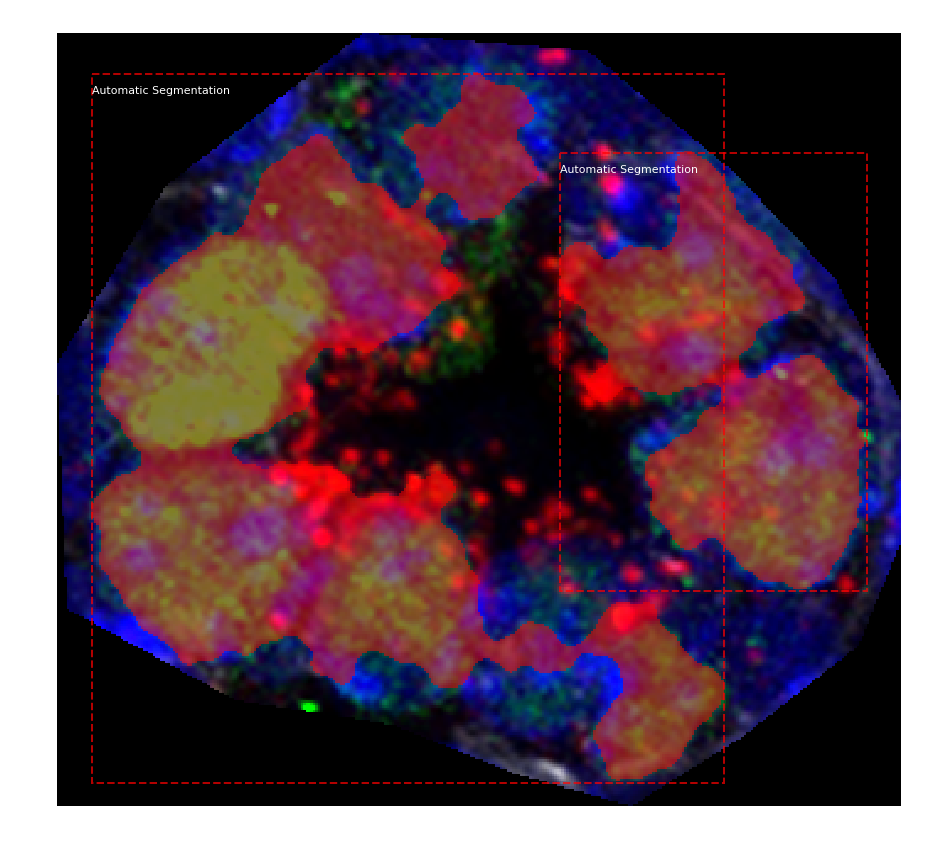

In [34]:
display_instances_segments(
    sub,
    contours_thresh_dict,
    ['raw']
)

> Now instead of merging contours together, it appears that we want to try to "pinch them off". We try to identify an automatic approach to such a problem